#### Example using DEMReg and SDO/AIA data
Here using synthetic SDO/AIA data for a single "pixel" generated from a Gaussian DEM 

This example is about plotting uncertaintiy region instead of specific error bars

* 24-Nov-2022 IGH

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io

# So can have single copy of demreg on system, and don't need copy in working directory
from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/Users/iain/github/demreg/python')
from dn2dem_pos import dn2dem_pos

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]
matplotlib.rcParams['font.size'] = 16

In [3]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
# Add in 10% systematic as well
edn_in=(rdnse**2+shotnoise**2+(0.1*dn_in)**2)**0.5 
# edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)
print('frac err:',edn_in/dn_in)

dn_in:  [  326.11015384   313.31711081  2663.51032443 11361.19771881
  8700.35613926  1208.36625448]
edn_in:  [  35.87261299   33.7972172   268.2815952  1137.77748117  871.55193999
  121.83165794]
frac err: [0.11000152 0.10786904 0.10072482 0.10014591 0.10017428 0.10082345]


In [4]:
# based off of my previous get_error_area.pro
# Mostly works, but interp can go a bit funny at times
def get_error_bound(d,ed,l,el,xlim=[5.7,7.2],ylim=[2e20,4e23]):
    n=len(l)

    # interpolate horizontal error limits the temperature binning
    d0=d
    d0[d0<= ylim[0]]=ylim[0]

    m1=np.interp(l,l-el,d0)
    m2=np.interp(l,l+el,d0)
    # m1=np.interp(l-el,l,d0)
    # m2=np.interp(l+el,l,d0)

    mind=d-ed
    # some checks to make sure within chosen limts, if not set to them
    mind[mind<=ylim[0]]=ylim[0]
    mind[mind>=ylim[1]]=ylim[1]

    bot=np.zeros(n)
    for i in np.arange(0,n): 
        bot[i]=np.min([m1[i],m2[i],mind[i]])

    # do the top most points
    maxd=d+ed
    maxd[maxd<=ylim[0]]=ylim[0]
    maxd[maxd>=ylim[1]]=ylim[1]

    top=np.zeros(n)
    for i in np.arange(0,n): 
        top[i]=np.max([m1[i],m2[i],maxd[i]])

    # create the arrays ready for the polyfill plotting
    xx=np.concatenate(([l[0]-el[0]],[l[0]],l,[l[-1]+el[-1]],[l[-1]+el[-1]],np.flip(l),[l[0]],[l[0]-el[0]]))
    yy=np.concatenate(([top[0]],[top[0]],top,[top[-1]],[bot[-1]],np.flip(bot),[l[0]],[l[0]]))

    yy[yy < ylim[0]]=ylim[0]
    yy[yy > ylim[1]]=ylim[1]
    xx[xx < xlim[0]]=xlim[0]
    xx[xx > xlim[1]]=xlim[1]

    return xx,yy


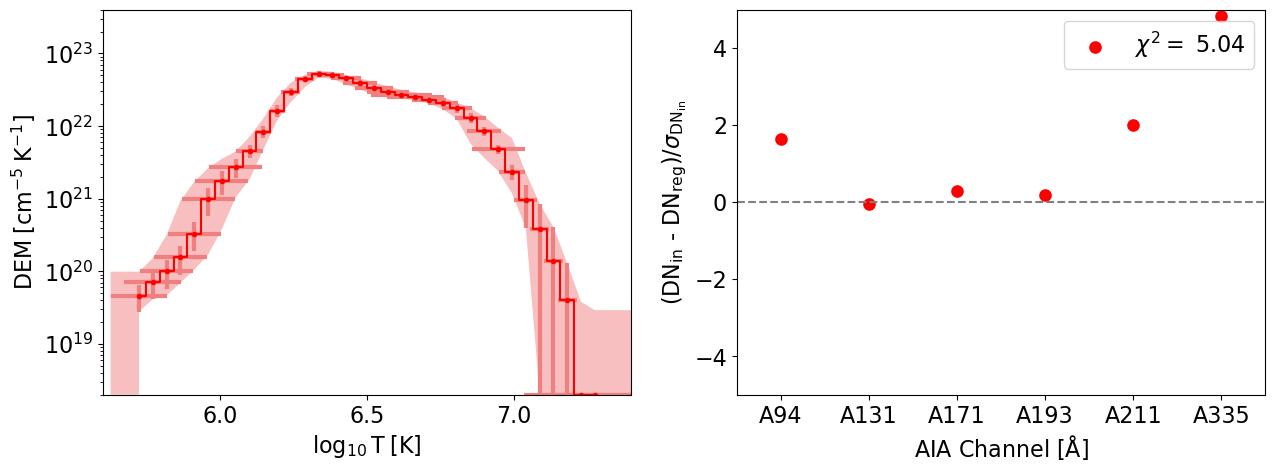

In [5]:
temps=np.logspace(5.7,7.3,num=35)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
yr=[2e18,4e23]
xr=[np.log10(np.min(temps))-.1,np.log10(np.max(temps))+.1]

# Now work out the DEM - investigate 3 standard ways of running
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)

xx0,yy0=get_error_bound(dem0,edem0,mlogt,elogt0,xlim=xr,ylim=yr)

fig= plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

ax1 = fig.add_subplot(1, 2, 1)
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='.r',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='94-335$\mathrm{\AA}$')
plt.step(mlogt,dem0,where='mid',color='red',label='94-335$\mathrm{\AA}$')
plt.fill(xx0,yy0,"lightcoral",alpha=0.5,label="demreg err")
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
# plt.legend()
plt.yscale('log')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(np.arange(6),(dn_in-dn_reg0)/edn_in,marker='o',color='red',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq0))
plt.plot([-1,12],[0,0],'--',color='grey')
plt.ylim([-5,5])
plt.xlim([-0.5,5.5])
plt.xticks(np.arange(6),trin['channels'])
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('(DN$_\mathrm{in}$ - DN$_\mathrm{reg}$)/$\sigma_\mathrm{DN_{in}}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()

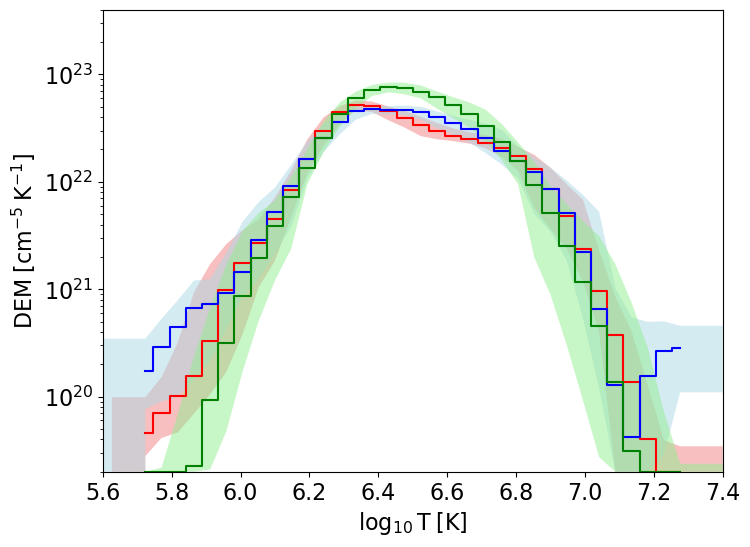

In [6]:
#  Example of several DEMs overplotted
temps=np.logspace(5.7,7.3,num=35)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
yr=[2e19,4e23]
xr=[np.log10(np.min(temps))-.1,np.log10(np.max(temps))+.1]

dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps) 
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1)
demwght0=10**np.interp(mlogt,tresp_logt,np.log10(dem_mod))
dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=demwght0/max(demwght0)) 
xx0,yy0=get_error_bound(dem0,edem0,mlogt,elogt0,xlim=xr,ylim=yr)
xx1,yy1=get_error_bound(dem1,edem1,mlogt,elogt1,xlim=xr,ylim=yr)
xx2,yy2=get_error_bound(dem2,edem2,mlogt,elogt2,xlim=xr,ylim=yr)

fig= plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.step(mlogt,dem0,where='mid',color='red')
plt.fill(xx0,yy0,"lightcoral",alpha=0.5)
plt.step(mlogt,dem1,where='mid',color='blue')
plt.fill(xx1,yy1,"lightblue",alpha=0.5)
plt.step(mlogt,dem2,where='mid',color='green')
plt.fill(xx2,yy2,"lightgreen",alpha=0.5)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')

plt.ylim(yr)
plt.xlim(xr)
# plt.legend()
plt.yscale('log')

plt.show()